# Simple RNN을 이용한 SMS spam분류

## RNN 순서  

데이터 전처리  
- null 값 확인  
- 중복 값 확인  
- Y값 처리(분류의 경우 0/1로 바꾸는 등)  

텍스트 전처리  
- 구두점 처리  
- 토큰화  
- RNN에 넣기 위해서는 X데이터의 사이즈가 같아야 하므로 패딩을 해준다  
- 트레인 / 테스트셋 분할  

모델  
- 임베딩  
- SimpleRNN 
- Dense


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

### 데이터 전처리

In [3]:
df = pd.read_csv('data/spam.csv')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


필요한 열 : v1, v2  
또한 v1의 경우, 0과 1로 바꾸어줘야 한다. 

In [5]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']

df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
df.v1 = df.v1.replace(['ham','spam'],[0,1])         # LabelEncoder 사용해도 가능하다 
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


NULL 값 확인

In [11]:
df.isnull().sum()           # 널 값 없음

v1    0
v2    0
dtype: int64

중복 여부 

In [15]:
df.v2.nunique()         # 중복이 있다는 뜻(5572가 나와야 함)

5169

In [16]:
# 중복 데이터 제거 - 네이버 영화평 분석에서 했었음(drop_duplicates)
df = df.drop_duplicates('v2',keep='first')

In [18]:
# Ham/Spam 데이터 갯수 확인
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

X와 Y 분할

In [19]:
X_data = df.v2.values
y_data = df.v1.values

### 텍스트 전처리

구둣점 제거, 소문자로 변환

In [22]:
from string import punctuation
def preprocessing(s):
    s = s.encode('utf8').decode('ascii','ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [23]:
X_data = [preprocessing(s) for s in X_data]
X_data[:2]

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni']

토크나이저  
단어 집합을 만들고 크기를 확인한다.  


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [27]:
t = Tokenizer()
t.fit_on_texts(X_data)          # fit_on_sequences아님!
vocab_size = len(t.word_index) + 1
vocab_size

9480

In [28]:
sequences = t.texts_to_sequences(X_data)
print(sequences[1])

[51, 281, 1290, 411, 6, 1666]


In [30]:
max_len = max(len(l) for l in sequences)
max_len

171

전체 데이터셋의 길이를 max_len에 맞추기

In [33]:
data = pad_sequences(sequences, maxlen = max_len)
data.shape

(5169, 171)

테스트 / 트레인 세트 분할

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(data, y_data, stratify=y_data, test_size=0.2, random_state=seed)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 정의 / 설정 / 학습

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

이전에는 Y값이 마지막 열이라 max_len에 포함이 되어 있어서 input_length에서 -1을 해준 것.  
지금은 따로 있으므로 그럴 필요 없다

In [38]:
model = Sequential([
    Embedding(vocab_size, 32,input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 171, 32)           303360    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 305,473
Trainable params: 305,473
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(
    optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy']
)

In [40]:
history = model.fit(X_train,y_train,epochs=10, batch_size = 60, validation_split = 0.2, verbose = 2)

Epoch 1/10
56/56 - 2s - loss: 0.3853 - accuracy: 0.8700 - val_loss: 0.3145 - val_accuracy: 0.8888
Epoch 2/10
56/56 - 1s - loss: 0.1574 - accuracy: 0.9550 - val_loss: 0.0768 - val_accuracy: 0.9831
Epoch 3/10
56/56 - 1s - loss: 0.0608 - accuracy: 0.9843 - val_loss: 0.0608 - val_accuracy: 0.9843
Epoch 4/10
56/56 - 1s - loss: 0.0229 - accuracy: 0.9952 - val_loss: 0.0606 - val_accuracy: 0.9831
Epoch 5/10
56/56 - 1s - loss: 0.0199 - accuracy: 0.9952 - val_loss: 0.0690 - val_accuracy: 0.9807
Epoch 6/10
56/56 - 1s - loss: 0.0104 - accuracy: 0.9982 - val_loss: 0.0652 - val_accuracy: 0.9807
Epoch 7/10
56/56 - 1s - loss: 0.0069 - accuracy: 0.9991 - val_loss: 0.0645 - val_accuracy: 0.9867
Epoch 8/10
56/56 - 1s - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0670 - val_accuracy: 0.9867
Epoch 9/10
56/56 - 1s - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.0749 - val_accuracy: 0.9782
Epoch 10/10
56/56 - 1s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0739 - val_accuracy: 0.9794


In [41]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 5ms/step - loss: 0.0646 - accuracy: 0.9807


[0.06464002281427383, 0.9806576371192932]

### 학습 과정 시각화 

In [43]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = range(1, len(y_loss)+1)

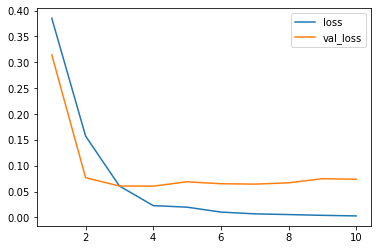

In [44]:
plt.plot(x_len, y_loss,label='loss')
plt.plot(x_len, y_vloss, label='val_loss')
plt.legend()
plt.show()

한 세번째 즈음에서 멈추는 것이 좋을 것 같다

### 기타 해볼 수 있는 것  
1. max_len을 100으로 설정  
        아마 큰 차이는 없겠지만, 학습이 빨리 될 듯  
2. 콜백을 사용, 베스트모델 저장  
3. n_embed, n_mm 등 값을 조절